In [1]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-09-05 12:00:00.945888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 12:00:00.968803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 12:00:00.968916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
from brainseg.models import siamese
from tensorflow.keras import optimizers

from brainseg.handlers.siamese_histo_mri import (SiameseHistoMRIHandler2, list_descriptors,
                                                 extract_monkey_from_mri, list_descriptors_histo_only)
from brainseg.provider import provider
from brainseg.loader import Loader
from brainseg.generator import X0TrainGenerator, X0TestGenerator
import glob
import pandas as pd
import numpy as np

from random import sample, choices, choice
from math import floor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from skimage.transform import resize

from itertools import groupby

In [3]:
HISTO_LOCATION = "/media/moi/KINGSTON/BrainMapping/slides_512/*"
HISTO_LOCATION_SELF = "/media/moi/KINGSTON/BrainMapping/slides_512_self/*"
MRI_LOCATION = "/media/moi/KINGSTON/BrainMapping/MRI/*/T1w/T1w_acpc_dc_restore.nii.gz"
MRI_LOCATION_SELF = "/home/moi/Downloads/oasis/*/*/*/PROCESSED/MPRAGE/T88_111/*t88_gfc.hdr"
MAPPING_FILE_LOCATION = "/media/moi/KINGSTON/BrainMapping/optimal_angles_/mapping_histo_mri_v3.csv"

In [4]:
slides = glob.glob(HISTO_LOCATION)
slides_self = glob.glob(HISTO_LOCATION_SELF)
mris = glob.glob(MRI_LOCATION)
mris_self = glob.glob(MRI_LOCATION_SELF)
mapping = pd.read_csv(MAPPING_FILE_LOCATION, index_col=0)

dict_mris = {extract_monkey_from_mri(x): x for x in mris}

In [5]:
seq = iaa.Sequential([
    # iaa.Rot90([0, 1, 2, 3]),
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-5, 5),
        shear=(-2, 2)
    ),
    iaa.LinearContrast((0.5, 2.5), per_channel=0.5),
    iaa.ElasticTransformation(alpha=(0.5, 1.5), sigma=0.25),
])

In [6]:
def split_by_monkey(descriptors, test_monkey):
    train, test = [], []
    for desc in descriptors:
        if desc["monkey_name"] == test_monkey:
            test.append(desc)
        else:
            train.append(desc)
            
    return train, test

In [7]:
descriptors = list_descriptors(slides, dict_mris, mapping)
# train_desc, test_desc = train_test_split(descriptors, test_size=0.1, random_state=0)
train_desc, test_desc = split_by_monkey(descriptors, test_monkey="M146")
descriptors_self = list_descriptors_histo_only(slides_self)

In [8]:
def group_desc_by_monkey(df):
    dict_mk = dict(list(df.groupby("monkey_name")))
    for k, v in dict_mk.items():
        # assert v.slide_id.is_unique, f"Slide ids not unique for {k} !"
        dict_mk[k] = v.sort_values("slide_id").reset_index()
    return dict_mk

In [9]:
def get_index(df, slide_id, col="slide_id"):
    indexes = df.index[df[col] == slide_id].tolist()
    if len(indexes) == 0:
        raise IndexError(f"Not found {slide_id}")
    return indexes[0]

In [10]:
def adjacent(df, slide_id, ascending=True, col="slide_id", count=1):
    index = get_index(df, slide_id, col=col)
    idx = df.index.get_loc(index)
    idx += count if ascending else -count
    return df.iloc[idx].to_dict()

In [11]:
def random_pick(df):
    return df.sample(n=1).iloc[0].to_dict()

In [12]:
def generate_triplets(dict_df, type_="histo"):  # type is just to fill the value, it does not change the behaviour
    ls = []
    for df in dict_df.values():
        for i, row in df.iterrows():
            try:
                anchor = row.to_dict()
                positive = adjacent(df, row["slide_id"], choice([True, False]))
                negative = random_pick(df)
            except:
                continue
            anchor["type"] = positive["type"] = negative["type"] = type_
            
            ls.append(dict(anchor=anchor, positive=positive, negative=negative))
    return ls

In [13]:
def is_included(a, low, high):
    return a >= low and a < high

In [14]:
def get_available_shift(index, shift, size):
    if is_included(index + shift, 0, size):
        return index + shift
    elif is_included(index - shift, 0, size):
        return index - shift
    else:
        raise ValueError()

In [15]:
def generate_triplets_v2(dict_df):
    ls = []
    for df in dict_df.values():
        size = len(df.index)
        for i, row in df.iterrows():
            try:
                anchor = row.to_dict()
                index = get_index(df, row["slide_id"])
                max_shift = size - index
                dir_ = choice([+1, -1])
                shift_pos = choice(range(0, 5)) * dir_
                shift_neg = choice(range(5 + shift_pos * 2, max_shift)) * dir_
                if not is_included(index + shift_neg, 0, size):
                    shift_pos, shift_neg = -shift_pos, -shift_neg
                index_pos = index + shift_pos
                index_neg = index + shift_neg
                positive = df.iloc[index_pos].to_dict()
                negative = df.iloc[index_neg].to_dict()
            except:
                continue
            
            ls.append(dict(anchor=anchor, positive=positive, negative=negative))
    return ls

In [16]:
def set_triplets_type_pattern(triplets, pattern):
    for t in triplets:
        t["anchor"]["type"] = pattern[0]
        t["positive"]["type"] = pattern[1]
        t["negative"]["type"] = pattern[2]

def set_triplets_type_random(triplets):
    for t in triplets:
        t["anchor"]["type"] = choice(["histo", "mri"])
        t["positive"]["type"] = choice(["histo", "mri"])
        t["negative"]["type"] = choice(["histo", "mri"])

def set_triplets_type_constant(triplets, cst):
    for t in triplets:
        t["anchor"]["type"] = cst
        t["positive"]["type"] = cst
        t["negative"]["type"] = cst

def set_triplets_type(triplets, type_):
    if type_ == "random":
        set_triplets_type_random(triplets)
    elif isinstance(type_, str):
        set_triplets_type_constant(triplets, type_)
    elif len(type_) == 3:
        set_triplets_type_pattern(triplets, type_)

In [17]:
def triplets_from_raw_desc(desc, type_="histo"):
    df = pd.DataFrame(desc)
    dict_mk = group_desc_by_monkey(df)
    triplet_descriptors = generate_triplets_v2(dict_mk)
    set_triplets_type(triplet_descriptors, type_)
    return triplet_descriptors

In [18]:
def show_triplet_batch(triplet):
    plt.figure(figsize=(12, 8))
    batch_size = len(triplet[0])
    for i in range(batch_size):
        for nb in range(3):
            data = triplet[nb][i]
            plt.subplot(batch_size, 3, 3 * i + nb + 1)
            # kwargs = dict() if data.shape[2] == 3 else dict(cmap="gray")
            if data.shape[2] == 3:
                data = data[:, :, 2]
            plt.imshow(data, cmap="gray")
            
    plt.show()

In [19]:
def resize_and_pad_center(arr, height=256, width=256, background=0):
    if arr.ndim == 3:
        res = np.zeros((height, width, arr.shape[2]))
    elif arr.ndim == 2:
        res = np.zeros((height, width))
        
    res.fill(background)
    delta_x = floor((height - arr.shape[0]) / 2)
    delta_y = floor((width - arr.shape[1]) / 2)
    
    res[delta_x: delta_x + arr.shape[0],
        delta_y: delta_y + arr.shape[1]] = arr
    return res

In [20]:
def prepro_spe(x):
    if x.ndim == 2:  # proxy for "is mri"
        x = resize_and_pad_center(x).reshape((256, 256, 1))
        x = np.rot90(x, 1)
        x = np.repeat(x, 3, axis=2)
    elif x.ndim == 3:  # proxy for "is histo"
        x = resize(x, (256, 256))
    return x

def preprocess_siamese(x):
    x = map(np.asarray, x)
    x = map(lambda p: seq(image=p), x)
    x = map(lambda p: (p - p.mean()) / p.std(), x)
    x = map(prepro_spe, x)
    # REQUIRE AUGMENTATION
    origin, pos, neg = x
    return [origin, pos, neg]

In [21]:
shmh = SiameseHistoMRIHandler2()
provider.register(shmh)

In [22]:
siamese_network = siamese.get_siamese_model_uniform((256, 256, 3))

2022-09-05 12:00:02.635401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-05 12:00:02.636625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 12:00:02.636751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 12:00:02.636825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [23]:
def get_test_gen(test_desc, type_):
    test_triplets = sum([triplets_from_raw_desc(test_desc, type_=type_) for _ in range(10)], [])
    test_loader = Loader([(shmh.name, x) for x in test_triplets])
    test_gen = X0TestGenerator(test_loader, batch_size=4, preprocess=preprocess_siamese)
    return test_gen

In [24]:
test_gen_mri = get_test_gen(test_desc, "mri")
test_gen_histo = get_test_gen(test_desc, "histo")
test_gen_cross = get_test_gen(test_desc, ["histo", "mri", "mri"])

In [25]:
siamese_model = siamese.SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [26]:
def evaluate(model, test_gen):
    res = model.predict(test_gen)
    return (res[0] < res[1]).mean()

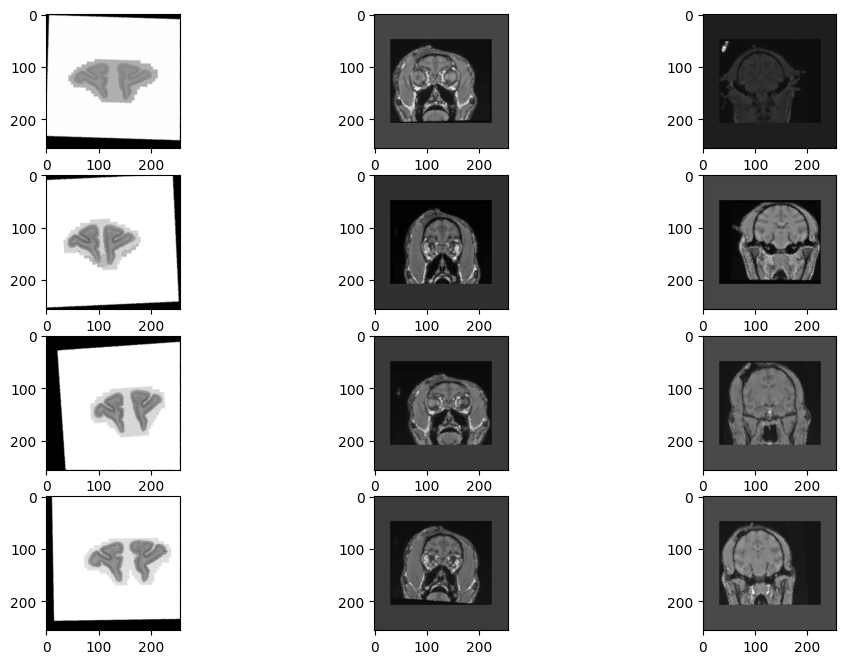

In [27]:
show_triplet_batch(test_gen_cross[0][0])

In [28]:
def generate_train_triplets(cross_histo_mri=None, only_histo=None, only_mri=None):
    all_ = []
    if cross_histo_mri is not None:
        all_ += triplets_from_raw_desc(cross_histo_mri, type_="histo")
        all_ += triplets_from_raw_desc(cross_histo_mri, type_="mri")
        all_ += triplets_from_raw_desc(cross_histo_mri, type_="random")
    
    if only_histo is not None:
        all_ += triplets_from_raw_desc(only_histo, type_="histo")
    
    if only_mri is not None:
        all_ += triplets_from_raw_desc(only_mri, type_="mri")
        
    return all_

In [29]:
for i in range(20):
    # train_triplets = triplets_from_raw_desc(train_desc, type_="mri")
    train_triplets = generate_train_triplets(train_desc, only_histo=descriptors_self)
    enriched_descriptors = [(shmh.name, x) for x in train_triplets]
    loader = Loader(enriched_descriptors)
    gen = X0TrainGenerator(loader, batch_size=4, preprocess=preprocess_siamese)
    siamese_model.fit(gen, epochs=1)
    score = evaluate(siamese_model, test_gen_mri)
    print("Epoch", i, "\t\t", score, "mri")
    score = evaluate(siamese_model, test_gen_histo)
    print("Epoch", i, "\t\t", score, "histo")
    score = evaluate(siamese_model, test_gen_cross)
    print("Epoch", i, "\t\t", score, "cross")

2022-09-05 12:00:17.078890: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-05 12:00:17.407062: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


322/322 [==============================] - 16s 40ms/step
Epoch 0 		 0.7153965785381027 mri
323/323 [==============================] - 113s 348ms/step
Epoch 0 		 0.5950349107835532 histo
322/322 [==============================] - 47s 146ms/step
Epoch 0 		 0.47707847707847706 cross
322/322 [==============================] - 13s 41ms/step
Epoch 1 		 0.833592534992224 mri
323/323 [==============================] - 111s 342ms/step
Epoch 1 		 0.6004654771140419 histo
322/322 [==============================] - 46s 142ms/step
Epoch 1 		 0.6045066045066045 cross
322/322 [==============================] - 13s 41ms/step
Epoch 2 		 0.8530326594090202 mri
323/323 [==============================] - 110s 342ms/step
Epoch 2 		 0.6252909231962762 histo
322/322 [==============================] - 46s 142ms/step
Epoch 2 		 0.5547785547785548 cross
322/322 [==============================] - 13s 41ms/step
Epoch 3 		 0.8600311041990669 mri
323/323 [==============================] - 112s 346ms/step
Epoch 3 		

In [30]:
res = siamese_model.predict(test_gen_cross)

322/322 [==============================] - 46s 141ms/step


-0.8706597


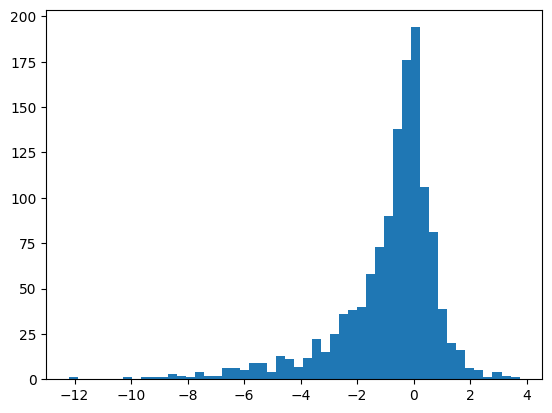

In [31]:
print(np.mean(res[0] - res[1]))
plt.hist(res[0] - res[1], bins=50)
pass

[-1.2134126  1.1490664  2.251824  -6.7344155]


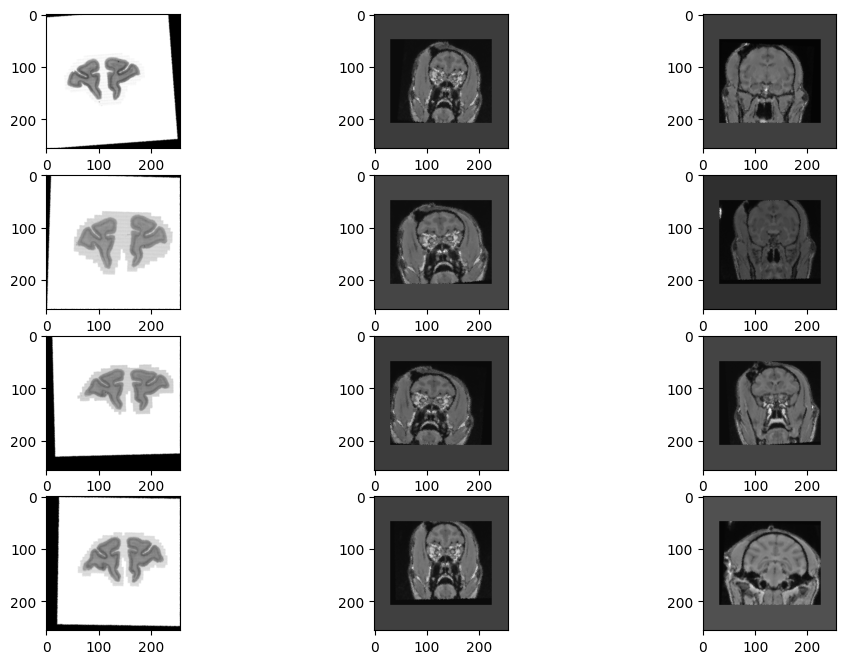

In [32]:
nbatch = 1
slices = slice(nbatch * 4, (nbatch + 1) * 4)
print(res[0][slices] - res[1][slices])
show_triplet_batch(test_gen_cross[nbatch][0])

In [33]:
test_gen_cross.data.data[4]

('siamese_histo_mri',
 {'anchor': {'index': 4,
   'image_name': '/media/moi/KINGSTON/BrainMapping/slides_512/M146 LHRH073.png',
   'mri_name': '/media/moi/KINGSTON/BrainMapping/MRI/M146/T1w/T1w_acpc_dc_restore.nii.gz',
   'monkey_name': 'M146',
   'slide_id': 73,
   'rotx': -2,
   'rotz': 0,
   'mri_id': 154,
   'type': 'histo'},
  'positive': {'index': 8,
   'image_name': '/media/moi/KINGSTON/BrainMapping/slides_512/M146 LHRH089.png',
   'mri_name': '/media/moi/KINGSTON/BrainMapping/MRI/M146/T1w/T1w_acpc_dc_restore.nii.gz',
   'monkey_name': 'M146',
   'slide_id': 89,
   'rotx': -2,
   'rotz': 0,
   'mri_id': 150,
   'type': 'mri'},
  'negative': {'index': 60,
   'image_name': '/media/moi/KINGSTON/BrainMapping/slides_512/M146 LHRH211.png',
   'mri_name': '/media/moi/KINGSTON/BrainMapping/MRI/M146/T1w/T1w_acpc_dc_restore.nii.gz',
   'monkey_name': 'M146',
   'slide_id': 211,
   'rotx': -2,
   'rotz': 0,
   'mri_id': 119,
   'type': 'mri'}})

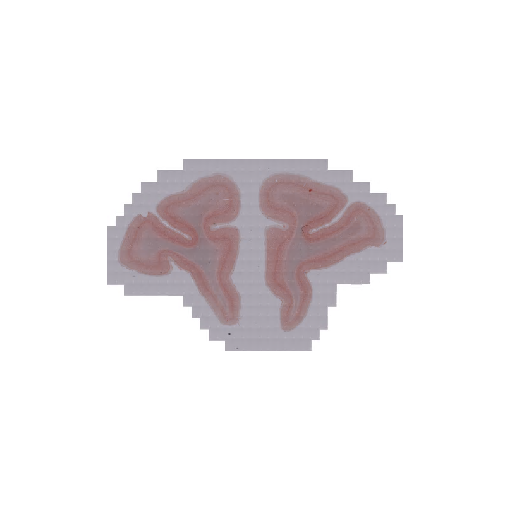

In [34]:
test_gen_cross.data[4][0][0]

In [35]:
provider